In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
from tensorflow.keras.layers import Embedding, Flatten, LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input
from keras.models import load_model
import matplotlib.pyplot as plt



In [42]:
# Load the data
data_path = "../data/Eye-tracking Output/cleaned_data.csv"
df = pd.read_csv(data_path)


In [43]:
## Normalizing data ##

# Feature selection of relevant columns
relevant_columns = ['Participant', 'Point of Regard Right X [px]', 'Point of Regard Right Y [px]',
                    'Tracking Ratio [%]', 'Category Right',
                    'Stimulus', 'Gender', 'Age', 'Class', 'Trial', 'Pupil Diameter Right [mm]', 'Time.s']

df_relevant = df[relevant_columns]

# Filling NaNs in 'CARS Score' with 0
df_relevant['Age'].fillna(0, inplace=True)

# List of numerical columns to scale
numerical_columns = ['Point of Regard Right X [px]', 'Point of Regard Right Y [px]', 'Pupil Diameter Right [mm]', 'Time.s'
                     ] # Lidt i tvivl om vi skal have 'Age' med her. CARS og Age giver også 0. Pis lort

# Convert columns to numeric, coercing errors to NaN
for col in numerical_columns:
    df_relevant[col] = pd.to_numeric(df_relevant[col], errors='coerce')

# Define a function to fill NaN with the mean of the previous and next row
def fill_with_row_mean(df_relevant, col):
    # First, forward fill the first NaN (if any)
    df_relevant[col] = df_relevant[col].fillna(method='ffill')
    
    # Then, fill the rest with the mean of the previous and next row
    df_relevant[col] = df_relevant[col].fillna((df_relevant[col].shift(1) + df_relevant[col].shift(-1)) / 2)
    
    return df_relevant[col]

# Apply this function to each numerical column
for col in numerical_columns:
    df_relevant[col] = fill_with_row_mean(df_relevant, col)

# Handle any remaining NaNs, especially at the end of the DataFrame
df_relevant.fillna(method='bfill', inplace=True)

# Normalize data per combination of Trial, Participant, and Stimulus
for (trial, participant, stimulus), group_data in df_relevant.groupby(['Trial', 'Participant', 'Stimulus']):
    scaler = MinMaxScaler()
    # Apply the scaler to all numerical columns for this group
    df_relevant.loc[group_data.index, numerical_columns] = scaler.fit_transform(group_data[numerical_columns])

# For some reason Age and CARS Score are not scaled properly, so we do it manually
scaler = MinMaxScaler()
df_relevant[['Age', 'Tracking Ratio [%]']] = scaler.fit_transform(df_relevant[['Age', 'Tracking Ratio [%]']])

# Save the normalized data
df_relevant.to_csv("../data/Eye-tracking Output/normalized_data.csv", index=False)

/var/folders/94/903y39c95x3g49g0_7l22jn00000gn/T/ipykernel_38004/1142433817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['Age'].fillna(0, inplace=True)
/var/folders/94/903y39c95x3g49g0_7l22jn00000gn/T/ipykernel_38004/1142433817.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant[col] = pd.to_numeric(df_relevant[col], errors='coerce')
/var/folders/94/903y39c95x3g49g0_7l22jn00000gn/T/ipykernel_38004/1142433817.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [44]:
df_relevant = pd.read_csv("../data/Eye-tracking Output/normalized_data.csv")
# Label encoding for participant, subject, and trial. 
# Input dimensions are the number of unique values in each column and output is the square root of the input
# embeddings = []
# inputs = ['Stimulus', 'Trial']
# input_dims = [114, 34]
# output_dims = [11, 7]

# for input_name, input_dim, output_dim in zip(inputs, input_dims, output_dims):
#     le = LabelEncoder()
#     df_relevant[input_name] = le.fit_transform(df_relevant[input_name])
    
#     input_layer = Input(shape=(1,))
#     embedding_layer = Embedding(input_dim=input_dim, output_dim=output_dim)(input_layer)
    
#     embeddings.append(embedding_layer)

# # Concatenate embeddings
# concatenated = Concatenate()(embeddings)

# # print(df_relevant['Stimulus'].unique())
# print(concatenated)


In [45]:
# checking the variables to convert into dummy variables.
from sklearn.preprocessing import LabelEncoder

# for column in df_relevant.columns:
#     print(column, " dtype: ", df_relevant.dtypes[column])
    # if df_relevant.dtypes[column] == "object":
    #     print(column)

# print(df_relevant["Gender"].unique())
# print(df_relevant["Category Left"].unique())
# print(df_relevant["Category Right"].unique())
# print(df_relevant["Trial"].unique())
# print(df_relevant["Stimulus"].unique())


#print(df_relevant["Gender"].unique())
le_gen = LabelEncoder()
df_relevant['Gender'] = le_gen.fit_transform(df_relevant['Gender']) # M, F


le_class = LabelEncoder()
df_relevant['Class'] = le_class.fit_transform(df_relevant['Class']) # ASD, TD


# Assuming 'Category' is your categorical variable in a DataFrame df
df_encoded = pd.get_dummies(df_relevant, columns=['Category Right', 'Stimulus'], prefix=['Category Right', 'Stimulus']) # one hot encoding

# print(df_encoded.iloc[:, 16:22].head(5)) # checking how it looks.

for column in df_encoded.columns: #convert int64 into float64 so network it expects the same value
    if df_encoded.dtypes[column] == "int64" or df_encoded.dtypes[column] == "uint8" or df_encoded.dtypes[column] == "float64":
        df_encoded[column] = df_encoded[column].astype('float32')

for column in df_encoded.columns:
    print(column, " dtype: ", df_encoded.dtypes[column])
#print(df_relevant["Class"].unique())
#print(df_relevant['Participant'].unique())



Participant  dtype:  float32
Point of Regard Right X [px]  dtype:  float32
Point of Regard Right Y [px]  dtype:  float32
Tracking Ratio [%]  dtype:  float32
Gender  dtype:  float32
Age  dtype:  float32
Class  dtype:  float32
Trial  dtype:  object
Pupil Diameter Right [mm]  dtype:  float32
Time.s  dtype:  float32
Category Right_-  dtype:  float32
Category Right_Blink  dtype:  float32
Category Right_Fixation  dtype:  float32
Category Right_Saccade  dtype:  float32
Category Right_Separator  dtype:  float32
Stimulus_01 coucou g.jpg  dtype:  float32
Stimulus_01 neutre3.avi  dtype:  float32
Stimulus_01vnvg151201b1.avi  dtype:  float32
Stimulus_02 coucou d.jpg  dtype:  float32
Stimulus_02 devant.jpg  dtype:  float32
Stimulus_02 neutre visage gris.jpg  dtype:  float32
Stimulus_03 devant.jpg  dtype:  float32
Stimulus_03 regard chien g.jpg  dtype:  float32
Stimulus_03 vole triste vs joie1.avi  dtype:  float32
Stimulus_04 b joie triste - copie.jpg  dtype:  float32
Stimulus_04 regard chien d.jpg  

In [46]:
#tror ikke vi skal bruge den her

# # Save only the normalized columns into a new DataFrame
# normalized_columns = ['Point of Regard Right X [px]', 'Point of Regard Right Y [px]',
#                       'Tracking Ratio [%]',
#                       'CARS Score', 'Age']
# df_normalized = df_relevant[normalized_columns]


# # Combining all data into a single tensor
# # reshaping the normalized data into 3d np array
# normalized_np = np.stack([df_normalized[col].values for col in df_normalized.columns], 1)
# # converting from np array to keras tensors
# normalized_tensor = tf.convert_to_tensor(normalized_np, dtype=tf.float32)

# # Add a dimension to normalized_tensor and df_encoded
# # This transforms them from shape (905519, 7) and (905519, 19) to (905519, 1, 7) and (905519, 1, 19)
# normalized_tensor_3d = tf.expand_dims(normalized_tensor, axis=1)
# df_encoded_3d = tf.expand_dims(df_encoded, axis=1)

# # Now you can concatenate along the last axis
# df_all = tf.keras.layers.Concatenate(axis=-1)([normalized_tensor_3d, df_encoded_3d, concatenated])





In [75]:
# train test split. infør også evt padding

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your data is loaded into a variable called 'df_encoded'
# Modify the following line based on the actual column name of 'Class'

# Extract the unique participant IDs
participant_ids = df_encoded['Participant'].unique()

# Split participant IDs into train and test sets
train_participant_ids, test_participant_ids = train_test_split(participant_ids, test_size=0.34, random_state=3)

# Filter data based on participant IDs
train_data = df_encoded[np.isin(df_encoded['Participant'], train_participant_ids)]
test_data = df_encoded[np.isin(df_encoded['Participant'], test_participant_ids)]

test_data_participants = test_data['Participant']

# Extract 'Class' column index dynamically and 
class_column_index = df_encoded.columns.get_loc('Class')
participant_column_index = df_encoded.columns.get_loc('Participant')


# Extract 'Class' values for train and test
train_labels = train_data.iloc[:, class_column_index].values
test_labels = test_data.iloc[:, class_column_index].values


train_labels = pd.get_dummies(train_labels, columns=['Class'], prefix=['Class']) # one hot encoding
test_labels = pd.get_dummies(test_labels, columns=['Class'], prefix=['Class']) # one hot encoding


# Drop the 'Class' and 'Participant' column from the data
train_data = train_data.drop(columns=['Class', 'Participant', 'Trial'])
test_data = test_data.drop(columns=['Class', 'Participant', 'Trial'])




# Convert data into tensors with 60 samples each
def create_tensors(data, labels, samples_per_tensor=60):
    num_tensors = len(data) // samples_per_tensor
    data_tensors = np.array_split(data[:num_tensors * samples_per_tensor], num_tensors)
    labels_tensors = np.array_split(labels[:num_tensors * samples_per_tensor], num_tensors)
    return np.stack(data_tensors), np.stack(labels_tensors) #, np.expand_dims(np.stack(labels_tensors), axis=-1)

train_data_tensors, train_label_tensors = create_tensors(train_data.values, train_labels)
test_data_tensors, test_label_tensors = create_tensors(test_data.values, test_labels)

test_data_participants_tensor, lol = create_tensors(test_data_participants.values, test_labels)

# checking if everythin looks good
# print(train_data_tensors.shape)
# print(test_data_tensors.shape)
# print(train_label_tensors.shape)
# print(test_label_tensors.shape)

# #checking up on my data before feeding it to network.
# for i in train_data.columns:
#     print(i, train_data.dtypes[i])


(9272, 60, 126)


In [48]:
# print(X.shape)

indices = torch.randperm(len(train_data_tensors))[:200]

lort = train_data_tensors[indices] # making a subset of 200

lort.shape 

(200, 60, 126)

In [49]:
from tensorflow.keras.models import Sequential
# Define the LSTM model

input_shape = (60, 126)
dropout = 0.2
learning_rate = 0.0004


def classification_model():
    model = Sequential()

    # Add an LSTM layer with, for example, 50 units
    model.add(LSTM(units=60, input_shape=input_shape, return_sequences=True))

    # Add a Dense layer with the number of classes as the output dimension and activation function
    model.add(Dense(units=50))

    model.add(Dense(units=2, activation='softmax'))

    # Compile the model with an optimizer, loss function, and metrics
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


    return model

model = classification_model()

history = model.fit(train_data_tensors, train_label_tensors, epochs = 5, batch_size= 10, validation_data= (test_data_tensors, test_label_tensors))


model.save('modelus1.h5')

# Saving the history of the model
import pickle

with open('modelus1_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

# Display a summary of the model's architecture
model.summary()

preds = model.predict(test_data_tensors)


Epoch 1/5
919/928 [============================>.] - ETA: 0s - loss: 0.4347 - accuracy: 0.7975

KeyboardInterrupt: 

In [73]:
# Hypertuning the model
from kerastuner import HyperModel
from tensorflow import keras

num_classes = 2  # Define the number of classes

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.LSTM(
            units=hp.Int('units', min_value=30, max_value=100, step=10),
            input_shape=(60, 126), return_sequences=True))
        model.add(keras.layers.Dense(
            units=hp.Int('additional_units', min_value=20, max_value=50, step=10),
            activation='relu'))  # Additional hidden layer
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(keras.layers.Dense(num_classes, activation='sigmoid'))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='binary_crossentropy',
            metrics=['accuracy'])
        return model

from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir1',
    project_name='helloworld1')

tuner.search(train_data_tensors, train_label_tensors, epochs = 5, batch_size= 10, validation_data= (test_data_tensors, test_label_tensors))

best_model = tuner.get_best_models(num_models=1)[0]

best_model.save('best_modelus1.h5')

# Saving the history of the model
history=best_model.history
with open('best_modelus1_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
import pickle



Reloading Tuner from my_dir1/helloworld1/tuner0.json

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
100               |70                |units
50                |50                |additional_units
0.35              |0.05              |dropout
0.0036991         |0.00010296        |learning_rate

Epoch 1/5
194/928 [=====>........................] - ETA: 11s - loss: 0.4956 - accuracy: 0.7818

KeyboardInterrupt: 

In [72]:
# Plotting to see if the model is overfitting
model = load_model('best_modelus1.h5')

# MODELLENS HISTORIK SKAL LOADS IND HER

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

In [52]:
#predictions
from keras.models import load_model

model = load_model('best_modelus1.h5')
preds = model.predict(test_data_tensors)

print(preds.shape)
print(test_label_tensors.shape)
# Assuming preds is the output of model.predict
import pandas as pd

# Assuming preds is the output of model.predict
predicted_class_labels = preds.argmax(axis=-1)
predicted_class_labels_df = pd.DataFrame({'Predicted_Class': predicted_class_labels[:, 0]}) #puts into dataframe

# Print the first 50 rows
#print(predicted_class_labels_df.head(50))

true_class_labels = test_label_tensors.argmax(axis=-1)
true_class_labels_df = pd.DataFrame({'Predicted_Class': true_class_labels[:, 0]}) #puts into dataframe

#print(true_class_labels_df[0:10])


# for i in predicted_class_labels_df['Predicted_Class'][60:100]:
#     print(i)

# for i in true_class_labels_df['Predicted_Class'][60:100]:
#     print(i)




182/182 [==============================] - 2s 8ms/step
(5819, 60, 2)
(5819, 60, 2)


In [57]:
### making a prediction function based on models guesses.
# print(preds.shape)
dol = pd.DataFrame(test_data_participants_tensor)
dol["Name"] = dol[1]
dol = dol.astype(object)

unique_indices = dol.drop_duplicates(subset="Name").index.tolist()

unique_indices.append(len(dol)) #appending last index

true_df_list = []
pred_df_list = []

for i in range(len(unique_indices)-1): #segment data
    if i == unique_indices[-1]:
        break
    start_index = unique_indices[i]
    end_index = unique_indices[i + 1]

    # print(start_index, end_index)

    true_list = true_class_labels_df[start_index: end_index]
    pred_list = predicted_class_labels_df[start_index: end_index]

    true_df_list.append(true_list)
    pred_df_list.append(pred_list)

pred_list = []
true_list = []

#now for the prediction:
for df in pred_df_list:
    avg = sum(df['Predicted_Class'])/len(df)
    if avg <= 0.5:
        pred = 1
    elif avg > 0.5:
        pred = 0
    pred_list.append(pred)

for df in true_df_list:
    avg = sum(df['Predicted_Class'])/len(df)
    if avg <= 0.5:
        pred1 = 1
    elif avg > 0.5:
        pred1 = 0
    true_list.append(pred1)


print(pred_list)
print(true_list)




[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]


In [58]:
#making a prediction function based on sum of outputs

print(preds.shape)
print(test_label_tensors.shape)

predictions = pd.DataFrame(preds[:, -1, :])
test_label = pd.DataFrame(test_label_tensors[:, -1, :])


print(test_label.head(5))


True_df_list = []
predict_df_list = []


for i in range(len(unique_indices)-1): #segment data
    if i == unique_indices[-1]:
        break
    start_index = unique_indices[i]
    end_index = unique_indices[i + 1]

    # print(start_index, end_index)

    true_list = predictions[start_index: end_index]
    pred_list = test_label[start_index: end_index]

    True_df_list.append(true_list)
    predict_df_list .append(pred_list)


# now for predictions


final_predictions = []
true_list = []

for i in True_df_list:
    sum_0 = sum(i[0])
    sum_1 = sum(i[1])
    if sum_0 > sum_1:
        final_predictions.append(1)
    else:
        final_predictions.append(0)


for df in true_df_list:
    avg = sum(df['Predicted_Class'])/len(df)
    if avg <= 0.5:
        pred1 = 1
    elif avg > 0.5:
        pred1 = 0
    true_list.append(pred1)
    
print(true_list)
print(final_predictions)



(5819, 60, 2)
(5819, 60, 2)
   0  1
0  1  0
1  1  0
2  1  0
3  1  0
4  1  0
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]


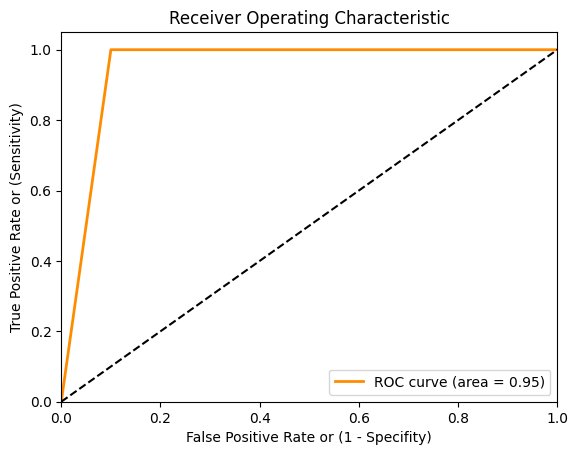

In [77]:
# Plotting a ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming preds is the output of model.predict
fpr, tpr, _ = roc_curve(true_list, final_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
        label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



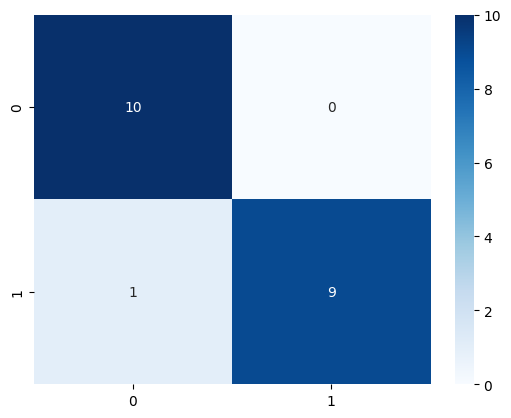

In [79]:
# Visualizing the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Flipping results so that 1 is ASD and 0 is TD
true_list = [1 if i == 0 else 0 for i in true_list]
final_predictions = [1 if i == 0 else 0 for i in final_predictions]


sns.heatmap(confusion_matrix(true_list, final_predictions), annot=True, cmap='Blues')

# Printing classification report
print(classification_report(true_list, final_predictions))


